In [1]:
import sys, os
from pathlib import Path
ROOT = Path.cwd().parent
if str(ROOT / 'src') not in sys.path:
    sys.path.insert(0, str(ROOT / 'src'))
print('Added to sys.path:', ROOT / 'src')


Added to sys.path: /home/spina/Desktop/units/DL/project/mice-representation/src


### Imports

In [2]:
import os
import sys
import os
import torch
from IPython.display import Image, display

sys.path.insert(0, os.path.abspath("src"))

from config import *
from datasets.DataManager import DataManager
from AlexNet import AlexNet
from neural_data.AllenDataLoader import AllenDataLoader
from neural_data.AllenDataViewer import AllenDataViewer

In [3]:
!bat ../src/config.py

]10;?]11;?───────┬────────────────────────────────────────────────────────────────────────
       │ File: ../src/config.py
───────┼────────────────────────────────────────────────────────────────────────
   1   │ import os
   2   │ from pathlib import Path
   3   │ 
   4   │ """Project-wide configuration constants.
   5   │ 
   6   │ All file-system locations are defined with `pathlib.Path` and resolved 
       │ relative
   7   │ to the repository layout to ensure portability and correctness.
   8   │ """
   9   │ 
  10   │ # discover important locations
  11   │ SRC_DIR = Path(__file__).resolve().parent
  12   │ ROOT = SRC_DIR.parent
  13   │ 
  14   │ #? ------------- logging constants -------------
  15   │ # Logs will be written under ROOT / "log"
  16   │ LOG_DIR = ROOT / "log"
  17   │ 
  18   │ #? ------------- Allen data constants -------------
  19   │ NEUROPIXELS_PKL_URL: str = "https://mouse-vision-neuraldata.s3.amazonaw
       │ s.com/mouse_neuropixels_visual_data_with

In [4]:
# This cell is used for constants override

DOWNLOAD_DATA = False
DOWNLOAD_ALLEN_DATA = False
CONVERT_ALLEN_DATA = False
VISUALIZE_ALLEN_DATA = True

LOAD_MODEL = True
TRAIN = True
TEST = True

NUM_EPOCHS = 300

### Initialize Data and Model

In [5]:
# detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print("Optimizations applied: Mixed Precision, Optimized DataLoader, Larger Batch Size")

data_manager = DataManager(
    data_path=MINI_IMAGENET_PATH,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    train_split=TRAIN_SPLIT,
    val_split=VAL_SPLIT
)
data_manager.setup()

model_manager = AlexNet(
    data_manager=data_manager,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    dropout_rate=DROPOUT_RATE,
    patience=PATIENCE,
    label_smoothing=LABEL_SMOOTHING
)

Using device: cuda
Optimizations applied: Mixed Precision, Optimized DataLoader, Larger Batch Size
Loading ImageFolder from /home/spina/.cache/kagglehub/datasets/arjunashok33/miniimagenet/versions/1
Dataset loaded: 60000 samples, 100 classes
Splitting dataset into train, val, and test sets
Train dataset: 41999 samples
Val dataset: 9000 samples
Test dataset: 9001 samples


#### Load Model

In [6]:
if LOAD_MODEL:
    if os.path.exists(CHECKPOINT_PATH):
        try:
            model_manager.load_model(CHECKPOINT_PATH)
        except Exception as e:
            print(f"Could not warm-start from {CHECKPOINT_PATH}: {e}")
    else:
        print(f"No checkpoint found at {CHECKPOINT_PATH}")

Model loaded from /home/spina/Desktop/units/DL/project/mice-representation/checkpoints/best_model.pth
Best validation loss: 4.3679
Best validation accuracy: 4.14%


#### Train

In [7]:
if TRAIN:
    #? -------------- Training --------------
    # Train the model
    training_history = model_manager.train()

    # Plot training history
    model_manager.plot_training_history()
    #? ---------------------------------------


Training


KeyboardInterrupt: 

### Test

In [ ]:
if TEST:
    test_loss, test_accuracy, test_accuracy5 = model_manager.test()

    print(f"Test Results - Loss: {test_loss:.4f}, Acc-Top1: {test_accuracy:.2f}%, Acc-Top5: {test_accuracy5:.2f}%")

Testing: 100%|██████████| 36/36 [00:17<00:00,  2.10it/s, Loss=4.6071, Acc@1=1.00%, Acc@5=5.21%]

Test Results - Loss: 4.6054, Acc-Top1: 1.00%, Acc-Top5: 5.21%


### Allen Dataset

In [ ]:
dataset = "neuropixels"   # or "calcium"
out = None                # output path for the PKL
path ="AllenData/neuropixels.zarr"               # path to an existing PKL

data_loader = AllenDataLoader(dataset=dataset)

if DOWNLOAD_ALLEN_DATA:
    saved_path = data_loader.download(out_path=out)

INFO:Initialized AllenDataLoader for neuropixels dataset


Convert data to a compatible type

In [ ]:
if CONVERT_ALLEN_DATA:
    os.system("REMOVE_ENV=1 src/neural_data/data_converter.sh")

Inspect data

In [ ]:
if VISUALIZE_ALLEN_DATA:
    data_viewer = AllenDataViewer(zarr_dir=str(ZARR_NEUROPIXELS))
    data_viewer.summary

Dataset opened from: /home/spina/Desktop/units/DL/project/mice-representation/AllenData/neuropixels.zarr
Dims: {'trials': 50, 'frame_id': 118, 'time_relative_to_stimulus_onset': 25, 'units': 8301, 'dim_0': 118, 'dim_1': 918, 'dim_2': 1174}
Variables: ['neural_data', 'stimuli']
stimuli: shape=(118, 918, 1174)
neural_data: shape=(50, 118, 25, 8301)



Plot a grid of stimuli frames

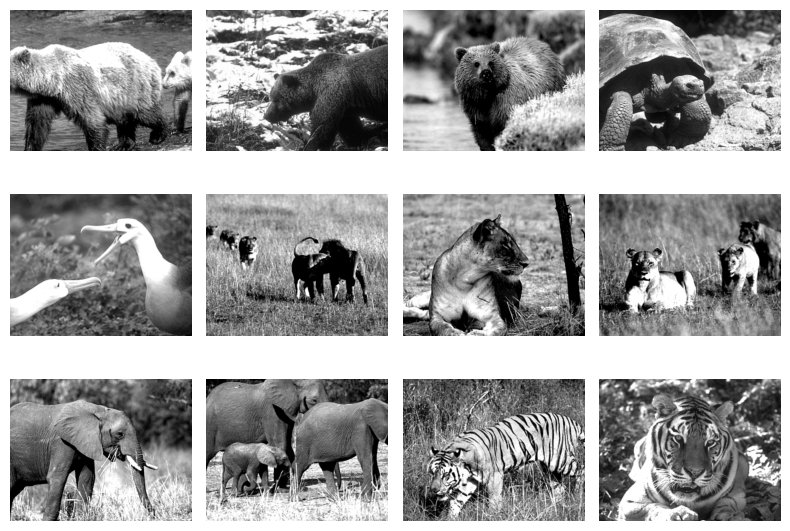

Saved stimuli grid to /home/spina/Desktop/units/DL/project/mice-representation/assets/stimuli_grid.png


In [ ]:
if VISUALIZE_ALLEN_DATA:
    stimuli_out = ROOT / Path("assets/stimuli_grid.png")
    stimuli_path = data_viewer.plot_stimuli_grid(
        out_path=str(stimuli_out),
        max_images=12,
        show=True
    )

Plot a heatmap of neural responses (optionally filtered by visual area)

In [ ]:
VISUAL_AREA = "VISp"

if VISUALIZE_ALLEN_DATA:
    responses_out = ROOT / Path("assets/neural_responses.png")
    responses_path = data_viewer.plot_neural_responses(
        out_path=str(responses_out),
        visual_area="VISrl",  # set e.g. "VISp" to filter if coord exists
        max_units=164,             # limit units for readability
        max_trials=100,           # limit trials for readability
        show=True
    )

KeyboardInterrupt: 

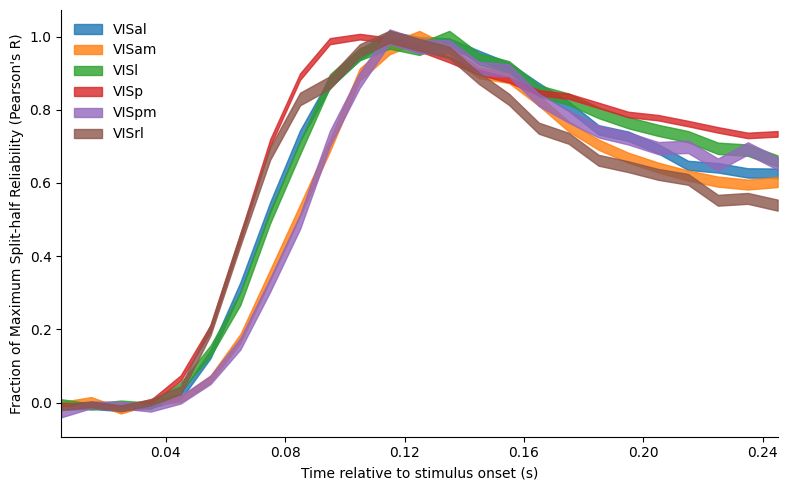

Saved reliability plot to /home/spina/Desktop/units/DL/project/mice-representation/assets/reliability.png


In [ ]:

if VISUALIZE_ALLEN_DATA:
    reliability_out = ROOT / Path("assets/reliability.png")

    data_viewer.plot_neuropixels_reliability(
        out_path=str(reliability_out),
        visual_areas=None,
        fraction_of_max=True,
        time_step_ms=0.1,
        show=True
    )